<center><font size = "10"> Week 10 - Network Stimulation<center>
<center><font size = "8">Home Work <center>

In [1]:
!nrnivmodl 

/home/In Silico Neuroscience/10 - Circuits II/Week10_Homework
vecevent.mod
vecevent.mod
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/usr/local/nrn/x86_64/lib"  vecevent.lo mod_func.lo  -L"/usr/local/nrn/x86_64/lib" -lnrnoc -loc -lmemacs  -lscopmath -lsparse13 -lreadline -lncurses -ltinfo -L"/usr/local/nrn/x86_64/lib" -lnrniv -livoc -lneuron_gnu -lmeschach -lsundials       -lm -ldl
libtool: link: rm -fr  .libs/libnrnmech.la .libs/libnrnmech.lai .libs/libnrnmech.so .libs/libnrnmech.so.0 .libs/libnrnmech.so.0.0.0
libtool: link: gcc -shared  -fPIC -DPIC  .libs/vecevent.o .libs/mod_func.o

In [2]:
%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np
import random

# Load external files & initialize
h.load_file("stdrun.hoc");
h.stdinit();

In [3]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self) # Notice this change to be able to instantiate several cells
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

In [4]:
from scipy.signal import find_peaks

def spike_detector(voltage, threshold):
    # convert Neuron recording (voltage) to list
    voltage_read = []
    for v in voltage:
        voltage_read.append(v)
    # peak locations
    spike_time, _ = find_peaks(voltage_read, height=threshold)
    return spike_time

In [5]:
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    rng = np.random.default_rng()
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return netcon

# Ex1. Irregular asynchrounous stimulation

<font size='3'>
Load the five morphology reconstructions assigned to your group in week 2 using the class "Cell" defined in the tutorials. 
Connect the pyramidal cells with weight = 1.0, similar to tutorial 01. Add exponential synapses (weight 1.0, tau = 2 ms) to a random section of the basal dendrite of each cell. Create an irregular asynchronous stimulation and apply it to each exponential synapse. Run a simulation that lasts at least past the last stimulation and plot the cells voltage response and spikes. What do you observe ? [1 pt]

In [6]:
# Initialize cells

Pyr1 = Cell('morph_02.swc','Pyr1','Pyr')
Int1 = Cell('morph_03.swc','Int1','Int')
Int2 = Cell('morph_05.swc','Int2','Int')
Pyr2 = Cell('morph_06.swc','Pyr2','Pyr')
Pyr3 = Cell('morph_10.swc','Pyr3','Pyr')
cells_Pyr = [Pyr1, Pyr2, Pyr3]
cells_Int = [Int1, Int2]
cells = cells_Pyr + cells_Int

error morph_02.swc line 19419: could not parse: 
error morph_03.swc line 2503: could not parse: 
error morph_05.swc line 5778: could not parse: 
error morph_06.swc line 14778: could not parse: 
error morph_10.swc line 8181: could not parse: 


In [7]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 29 apical sections, 38 basal sections, 2 soma sections and 217 axon senctions
Pyr2: 45 apical sections, 52 basal sections, 2 soma sections and 157 axon senctions
Pyr3: 46 apical sections, 37 basal sections, 2 soma sections and 81 axon senctions
Int1: 53 basal sections, 2 soma sections and 157 axon senctions
Int2: 36 basal sections, 2 soma sections and 131 axon senctions


In [8]:
# Connect Pyr cells with weight 1

netcons = [] # save the netcons in case we want to modify them later

# Connect Pyr1 and Pyr2 to Pyr3
nc = connect(Pyr1,Pyr3,weight = 1.0)
netcons.append(nc)
nc = connect(Pyr2,Pyr3,weight = 1.0)
netcons.append(nc)

# Connect Pyr1 and Pyr3 to Pyr2
nc = connect(Pyr1,Pyr2,weight = 1.0)
netcons.append(nc)
nc = connect(Pyr3,Pyr2,weight = 1.0)
netcons.append(nc)

# Connect Pyr2 and Pyr3 to Pyr1
nc = connect(Pyr2,Pyr1,weight = 1.0)
netcons.append(nc)
nc = connect(Pyr3,Pyr1,weight = 1.0)
netcons.append(nc)

Connected cells Pyr1 -> Pyr3 with weight 1 and delay 5, from axon[4] to dend[5]
Connected cells Pyr2 -> Pyr3 with weight 1 and delay 5, from axon[124] to dend[7]
Connected cells Pyr1 -> Pyr2 with weight 1 and delay 5, from axon[199] to dend[49]
Connected cells Pyr3 -> Pyr2 with weight 1 and delay 5, from axon[27] to dend[46]
Connected cells Pyr2 -> Pyr1 with weight 1 and delay 5, from axon[87] to dend[4]
Connected cells Pyr3 -> Pyr1 with weight 1 and delay 5, from axon[22] to dend[23]


In [9]:
# Place exponential synapses in random cell sections

# Exponential synapses
# Cell 1
sec1 = random.randint(0, len(Pyr1.dend)-1)
stim_cell1 = Pyr1
synapse1 = h.ExpSyn(stim_cell1.dend[sec1](0.5))
synapse1.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr1' %sec1)

# Cell 2
sec2 = random.randint(0, len(Pyr2.dend)-1)
stim_cell2 = Pyr2
synapse2 = h.ExpSyn(stim_cell2.dend[sec2](0.5))
synapse2.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr2' %sec2)

# Cell 3
sec3 = random.randint(0, len(Pyr3.dend)-1)
stim_cell3 = Pyr3
synapse3 = h.ExpSyn(stim_cell3.dend[sec3](0.5))
synapse3.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr3' %sec3)

Stimulus apply in basal section num 1 of Pyr1
Stimulus apply in basal section num 45 of Pyr2
Stimulus apply in basal section num 22 of Pyr3


In [10]:
# Create random stimulation times
stim_times1 = [20.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times1[t-1] + n
    stim_times1.append(step)
# Check what is the output
print('stimulation interval 1 = %s' %stim_times1)

stim_times2 = [30.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times2[t-1] + n
    stim_times2.append(step)
# Check what is the output
print('stimulation interval 2 = %s' %stim_times2)

stim_times3 = [10.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times3[t-1] + n
    stim_times3.append(step)
# Check what is the output
print('stimulation interval 3 = %s' %stim_times3)

stimulation interval 1 = [20.0, 54.0, 84.0, 94.0, 104.0, 117.0, 160.0]
stimulation interval 2 = [30.0, 70.0, 109.0, 145.0, 156.0, 185.0, 208.0]
stimulation interval 3 = [10.0, 36.0, 64.0, 87.0, 117.0, 154.0, 203.0]


In [11]:
# Stimulator
stimulator1 = h.VecStim()
spike_times1 = stim_times1
spikes_vector1 = h.Vector(spike_times1)
stimulator1.play(spikes_vector1)

stimulator2 = h.VecStim()
spike_times2 = stim_times2
spikes_vector2 = h.Vector(spike_times2)
stimulator2.play(spikes_vector2)

stimulator3 = h.VecStim()
spike_times3 = stim_times3
spikes_vector3 = h.Vector(spike_times3)
stimulator3.play(spikes_vector3)

connection1 = h.NetCon(stimulator1, synapse1)
connection1.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
connection2 = h.NetCon(stimulator2, synapse2)
connection2.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
connection3 = h.NetCon(stimulator3, synapse3)
connection3.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file

In [12]:
# record voltage from the soma and run the stimulation
recording_cell1 = Pyr1
recording_cell2 = Pyr2
recording_cell3 = Pyr3

soma_v1 = h.Vector().record(recording_cell1.soma[0](0.5)._ref_v)
soma_v2 = h.Vector().record(recording_cell2.soma[0](0.5)._ref_v)
soma_v3 = h.Vector().record(recording_cell3.soma[0](0.5)._ref_v)

time = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(350)

0.0

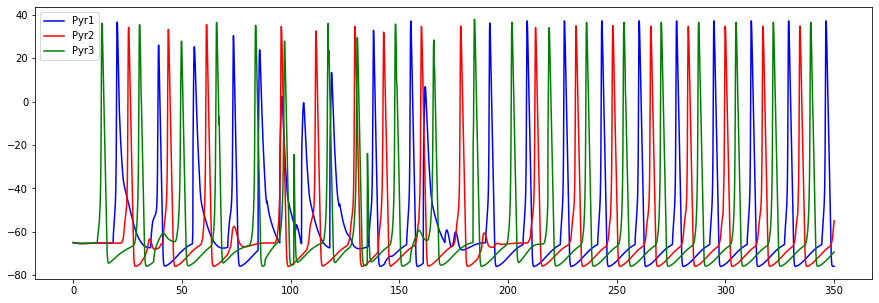

In [13]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v1, label='Pyr1', color='blue')
plt.plot(time, soma_v2, label='Pyr2', color='red')
plt.plot(time, soma_v3, label='Pyr3', color='green')
plt.legend()
plt.show()

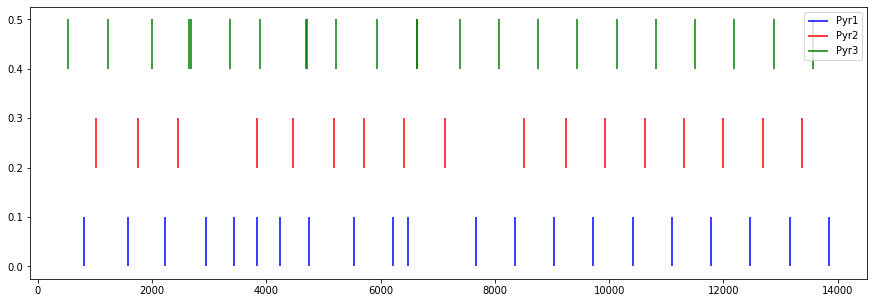

Spikes Pyr1  Pyr2  Pyr3
----------------------------------
       21    17    23


In [14]:
spikes1 = spike_detector(soma_v1, -20.0)
spikes2 = spike_detector(soma_v2, -20.0)
spikes3 = spike_detector(soma_v3, -20.0)

plt.figure(figsize=(15,5))
plt.vlines(spikes1, ymin=0, ymax=0.1, color='blue', label='Pyr1')
plt.vlines(spikes2, ymin=0.2, ymax=0.3, color='red', label='Pyr2')
plt.vlines(spikes3, ymin=0.4, ymax=0.5, color='green', label='Pyr3')
plt.legend()

plt.show()

print("Spikes Pyr1  Pyr2  Pyr3")
print("----------------------------------")
print("      ", len(spikes1), "  ", len(spikes2), "  ", len(spikes3))

We can observe that cell 3 reaches regular firing sooner than both cell 1 and cell 2. This is corresponding to the cell having an early first stimulation compared to the others. Similarly,cell 1 reaches regular firing sooner than cell 2 (20 ms vs 10 ms). Moreover, cell 1 has a regular firing patterns considerably later than the last stimulation epoch. This is also true for cell 2, but the pattern arises earlier in time (compared to last epoch). Cell 3 seems to have a way more stable firing pattern even before stimulation stops. Aditionally, all the cells keep firing after the last stimulation epoch.

# Ex2. Irregular asynchrounous stimulation with interneurons

<font size='3'>Perform the same simulation as before, but this time add the interneuron cells to your network with the following weights:
w(Pyr - Int) = 1, w(Inh - Pyr) = -0.01, w(Int - Int) = -0.01. Compare this result with the previous simulations. What is the role of the interneuron cells in this small network? [1 pt] 


In [15]:
# Add new connections (already done for Pyrs)

# Connect Pyr1, Pyr2 and Pyr 3 to Int2 with weight 1
nc = connect(Pyr1,Int1,weight = 1.0)
netcons.append(nc)
nc = connect(Pyr2,Int1,weight = 1.0)
netcons.append(nc)
nc = connect(Pyr3,Int1,weight = 1.0)
netcons.append(nc)

# Connect Pyr1, Pyr2 and Pyr 3 to Int2 with weight 1
nc = connect(Pyr1,Int2,weight = 1.0)
netcons.append(nc)
nc = connect(Pyr2,Int2,weight = 1.0)
netcons.append(nc)
nc = connect(Pyr3,Int2,weight = 1.0)
netcons.append(nc)

# Connect Int1 to Pyr1, Pyr2 and Pyr 3 with weight -0.01
nc = connect(Int1,Pyr1,weight = -0.01,target_neurite='soma')
netcons.append(nc)
nc = connect(Int1,Pyr2,weight = -0.01,target_neurite='soma')
netcons.append(nc)
nc = connect(Int1,Pyr3,weight = -0.01,target_neurite='soma')
netcons.append(nc)

# Connect Int2 to Pyr1, Pyr2 and Pyr 3 with weight -0.01
nc = connect(Int2,Pyr1,weight = -0.01,target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr2,weight = -0.01,target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr3,weight = -0.01,target_neurite='soma')
netcons.append(nc)

# Connect Int1 to Int2 and viceversa with weigh -0.01
nc = connect(Int1,Int2,weight = -0.01,target_neurite='soma') 
netcons.append(nc)
nc = connect(Int2,Int1,weight = -0.01,target_neurite='soma')
netcons.append(nc)

Connected cells Pyr1 -> Int1 with weight 1 and delay 5, from axon[89] to dend[52]
Connected cells Pyr2 -> Int1 with weight 1 and delay 5, from axon[27] to dend[18]
Connected cells Pyr3 -> Int1 with weight 1 and delay 5, from axon[20] to dend[47]
Connected cells Pyr1 -> Int2 with weight 1 and delay 5, from axon[118] to dend[15]
Connected cells Pyr2 -> Int2 with weight 1 and delay 5, from axon[92] to dend[22]
Connected cells Pyr3 -> Int2 with weight 1 and delay 5, from axon[69] to dend[34]
Connected cells Int1 -> Pyr1 with weight -0.01 and delay 5, from axon[122] to soma[1]
Connected cells Int1 -> Pyr2 with weight -0.01 and delay 5, from axon[79] to soma[0]
Connected cells Int1 -> Pyr3 with weight -0.01 and delay 5, from axon[70] to soma[0]
Connected cells Int2 -> Pyr1 with weight -0.01 and delay 5, from axon[25] to soma[0]
Connected cells Int2 -> Pyr2 with weight -0.01 and delay 5, from axon[51] to soma[1]
Connected cells Int2 -> Pyr3 with weight -0.01 and delay 5, from axon[51] to soma

In [16]:
# Place exponential synapses in random cell sections

# Exponential synapses for Pyrs already created 

print ('Stimulus apply in basal section num %s of Pyr1' %sec1)
print ('Stimulus apply in basal section num %s of Pyr2' %sec2)
print ('Stimulus apply in basal section num %s of Pyr3' %sec3)

# Cell 4
sec4 = random.randint(0, len(Int1.dend)-1)
stim_cell4 = Int1
synapse4 = h.ExpSyn(stim_cell4.dend[sec4](0.5))
synapse4.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Int1' %sec4)

# Cell 5
sec5 = random.randint(0, len(Int2.dend)-1)
stim_cell5 = Int2
synapse5 = h.ExpSyn(stim_cell5.dend[sec5](0.5))
synapse5.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Int2' %sec5)

Stimulus apply in basal section num 1 of Pyr1
Stimulus apply in basal section num 45 of Pyr2
Stimulus apply in basal section num 22 of Pyr3
Stimulus apply in basal section num 25 of Int1
Stimulus apply in basal section num 32 of Int2


In [17]:
# Create random stimulation times
# stim times from 1 to 3 created in exercise 1

print('stimulation interval 1 = %s' %stim_times1) 
print('stimulation interval 2 = %s' %stim_times2) 
print('stimulation interval 3 = %s' %stim_times3) 
    
stim_times4 = [15.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times4[t-1] + n
    stim_times4.append(step)
print('stimulation interval 4 = %s' %stim_times4) 

stim_times5 = [25.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times5[t-1] + n
    stim_times5.append(step)
print('stimulation interval 5 = %s' %stim_times5)

stimulation interval 1 = [20.0, 54.0, 84.0, 94.0, 104.0, 117.0, 160.0]
stimulation interval 2 = [30.0, 70.0, 109.0, 145.0, 156.0, 185.0, 208.0]
stimulation interval 3 = [10.0, 36.0, 64.0, 87.0, 117.0, 154.0, 203.0]
stimulation interval 4 = [15.0, 65.0, 92.0, 116.0, 160.0, 202.0, 240.0]
stimulation interval 5 = [25.0, 53.0, 96.0, 113.0, 132.0, 147.0, 193.0]


In [18]:
# Stimulator
stimulator1 = h.VecStim()
spike_times1 = stim_times1
spikes_vector1 = h.Vector(spike_times1)
stimulator1.play(spikes_vector1)

stimulator2 = h.VecStim()
spike_times2 = stim_times2
spikes_vector2 = h.Vector(spike_times2)
stimulator2.play(spikes_vector2)

stimulator3 = h.VecStim()
spike_times3 = stim_times3
spikes_vector3 = h.Vector(spike_times3)
stimulator3.play(spikes_vector3)

stimulator4 = h.VecStim()
spike_times4 = stim_times4
spikes_vector4 = h.Vector(spike_times4)
stimulator4.play(spikes_vector4)

stimulator5 = h.VecStim()
spike_times5 = stim_times5
spikes_vector5 = h.Vector(spike_times5)
stimulator5.play(spikes_vector5)

connection1 = h.NetCon(stimulator1, synapse1)
connection1.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
connection2 = h.NetCon(stimulator2, synapse2)
connection2.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
connection3 = h.NetCon(stimulator3, synapse3)
connection3.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
connection4 = h.NetCon(stimulator4, synapse4)
connection4.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
connection5 = h.NetCon(stimulator5, synapse5)
connection5.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file

In [19]:
# record voltage from the soma and run the stimulation

recording_cell1 = Pyr1
recording_cell2 = Pyr2
recording_cell3 = Pyr3
recording_cell4 = Int1
recording_cell5 = Int2

soma_v1 = h.Vector().record(recording_cell1.soma[0](0.5)._ref_v)
soma_v2 = h.Vector().record(recording_cell2.soma[0](0.5)._ref_v)
soma_v3 = h.Vector().record(recording_cell3.soma[0](0.5)._ref_v)
soma_v4 = h.Vector().record(recording_cell4.soma[0](0.5)._ref_v)
soma_v5 = h.Vector().record(recording_cell5.soma[0](0.5)._ref_v)

time = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(350)

0.0

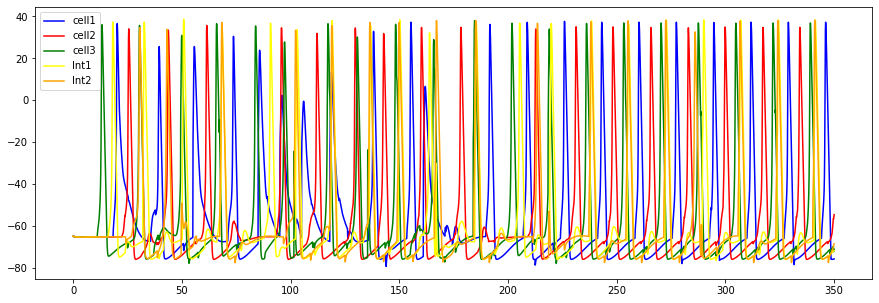

In [20]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v1, label='cell1', color='blue')
plt.plot(time, soma_v2, label='cell2', color='red')
plt.plot(time, soma_v3, label='cell3', color='green')
plt.plot(time, soma_v4, label='Int1', color='yellow')
plt.plot(time, soma_v5, label='Int2', color='orange')
plt.legend()
plt.show()

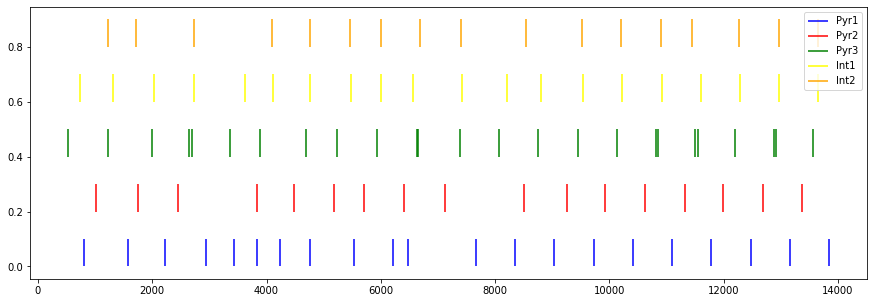

Spikes Pyr1  Pyr2  Pyr3  It1  Int2
----------------------------------
       21    17    25    20    17


In [21]:
spikes1 = spike_detector(soma_v1, -20.0)
spikes2 = spike_detector(soma_v2, -20.0)
spikes3 = spike_detector(soma_v3, -20.0)
spikes4 = spike_detector(soma_v4, -20.0)
spikes5 = spike_detector(soma_v5, -20.0)

plt.figure(figsize=(15,5))
plt.vlines(spikes1, ymin=0, ymax=0.1, color='blue', label='Pyr1')
plt.vlines(spikes2, ymin=0.2, ymax=0.3, color='red', label='Pyr2')
plt.vlines(spikes3, ymin=0.4, ymax=0.5, color='green', label='Pyr3')
plt.vlines(spikes4, ymin=0.6, ymax=0.7, color='yellow', label='Int1')
plt.vlines(spikes5, ymin=0.8, ymax=0.9, color='orange', label='Int2')
plt.legend()

plt.show()

print("Spikes Pyr1  Pyr2  Pyr3  It1  Int2")
print("----------------------------------")
print("      ", len(spikes1), "  ", len(spikes2), "  ", len(spikes3), "  ", len(spikes4), "  ", len(spikes5))

What is the role of the interneuron cells in this small network? 

Interneurons are key players in the synchronization of network activity. Based on the compartment they target (make synapse on) they can have different more specialised roles. For example, dendritic-targetting interneurons play vital roles in controlling plasticity and the efficacy of excitatory inputs onto principal cells. While, soma-targetting interneurons also play a role in the synchronization of the firing rates of principal cells.

# Ex3. Irregular asynchronous stimulation. Changing connection weights.

Load the five morphology reconstructions assigned to your group in week 2, using the class "Cell" defined in these tutorials and connect all cells with weight = 1. Add exponential synapses (weight 1, tau = 2 ms) to a random section of the basal dendrite of each cell. Create an irregular asynchronous stimulation and apply it to each exponential synapse. Run a simulation long enough to contain the last stimulation and plot the cells voltage response and the spikes.

1. Reduce the connection weight between your cells to 0.2, plot the same result as before and compare with the previous simulation. What do you observe ? Explain.

2. Return the connection weight between cells to its initial value of 1 and now reduce the connection weight of the expenential synapses to 0.2, plot the results and compare with the previous two simulations. What do you observe ? Is your network driven more by the stimulation or the connections between the cells. Explain [2 pts]

In [22]:
# Initialize cells

Pyr1 = Cell('morph_02.swc','Pyr1','Pyr')
Int1 = Cell('morph_03.swc','Int1','Int')
Int2 = Cell('morph_05.swc','Int2','Int')
Pyr2 = Cell('morph_06.swc','Pyr2','Pyr')
Pyr3 = Cell('morph_10.swc','Pyr3','Pyr')
cells_Pyr = [Pyr1, Pyr2, Pyr3]
cells_Int = [Int1, Int2]
cells = cells_Pyr + cells_Int

error morph_02.swc line 19419: could not parse: 
error morph_03.swc line 2503: could not parse: 
error morph_05.swc line 5778: could not parse: 
error morph_06.swc line 14778: could not parse: 
error morph_10.swc line 8181: could not parse: 


In [23]:
netcons = [] # save the netcons in case we want to modify them later
weight = 1

# Connect Pyr1 and Pyr2 to Pyr3
nc = connect(Pyr1,Pyr3,weight = weight)
netcons.append(nc)
nc = connect(Pyr2,Pyr3,weight = weight)
netcons.append(nc)

# Connect Pyr1 and Pyr3 to Pyr2
nc = connect(Pyr1,Pyr2,weight = weight)
netcons.append(nc)
nc = connect(Pyr3,Pyr2,weight = weight)
netcons.append(nc)

# Connect Pyr2 and Pyr3 to Pyr1
nc = connect(Pyr2,Pyr1,weight = weight)
netcons.append(nc)
nc = connect(Pyr3,Pyr1,weight = weight)
netcons.append(nc)

# Connect Pyr1, Pyr2 and Pyr 3 to Int2 
nc = connect(Pyr1,Int1,weight = weight)
netcons.append(nc)
nc = connect(Pyr2,Int1,weight = weight)
netcons.append(nc)
nc = connect(Pyr3,Int1,weight = weight)
netcons.append(nc)

# Connect Pyr1, Pyr2 and Pyr 3 to Int2 
nc = connect(Pyr1,Int2,weight = weight)
netcons.append(nc)
nc = connect(Pyr2,Int2,weight = weight)
netcons.append(nc)
nc = connect(Pyr3,Int2,weight = weight)
netcons.append(nc)

# Connect Int1 to Pyr1, Pyr2 and Pyr 3 
nc = connect(Int1,Pyr1,weight = weight,target_neurite='soma')
netcons.append(nc)
nc = connect(Int1,Pyr2,weight = weight,target_neurite='soma')
netcons.append(nc)
nc = connect(Int1,Pyr3,weight = weight,target_neurite='soma')
netcons.append(nc)

# Connect Int2 to Pyr1, Pyr2 and Pyr 3 
nc = connect(Int2,Pyr1,weight = weight,target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr2,weight = weight,target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr3,weight = weight,target_neurite='soma')
netcons.append(nc)

# Connect Int1 to Int2 and viceversa 
nc = connect(Int1,Int2,weight = weight,target_neurite='soma') 
netcons.append(nc)
nc = connect(Int2,Int1,weight = weight,target_neurite='soma')
netcons.append(nc)

Connected cells Pyr1 -> Pyr3 with weight 1 and delay 5, from axon[63] to dend[6]
Connected cells Pyr2 -> Pyr3 with weight 1 and delay 5, from axon[129] to dend[16]
Connected cells Pyr1 -> Pyr2 with weight 1 and delay 5, from axon[97] to dend[36]
Connected cells Pyr3 -> Pyr2 with weight 1 and delay 5, from axon[63] to dend[18]
Connected cells Pyr2 -> Pyr1 with weight 1 and delay 5, from axon[58] to dend[28]
Connected cells Pyr3 -> Pyr1 with weight 1 and delay 5, from axon[10] to dend[29]
Connected cells Pyr1 -> Int1 with weight 1 and delay 5, from axon[44] to dend[3]
Connected cells Pyr2 -> Int1 with weight 1 and delay 5, from axon[64] to dend[48]
Connected cells Pyr3 -> Int1 with weight 1 and delay 5, from axon[31] to dend[12]
Connected cells Pyr1 -> Int2 with weight 1 and delay 5, from axon[96] to dend[21]
Connected cells Pyr2 -> Int2 with weight 1 and delay 5, from axon[82] to dend[11]
Connected cells Pyr3 -> Int2 with weight 1 and delay 5, from axon[33] to dend[10]
Connected cells I

In [24]:
# get random sections 
sec1 = random.randint(0, len(Pyr1.dend)-1)
sec2 = random.randint(0, len(Pyr2.dend)-1)
sec3 = random.randint(0, len(Pyr3.dend)-1)
sec4 = random.randint(0, len(Int1.dend)-1)
sec5 = random.randint(0, len(Int2.dend)-1)

# create synapses 
stim_cell1 = Pyr1
synapse1 = h.ExpSyn(stim_cell1.dend[sec1](0.5))
synapse1.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr1' %sec1)

stim_cell2 = Pyr2
synapse2 = h.ExpSyn(stim_cell2.dend[sec2](0.5))
synapse2.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr2' %sec2)

stim_cell3 = Pyr3
synapse3 = h.ExpSyn(stim_cell3.dend[sec3](0.5))
synapse3.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr3' %sec3)

stim_cell4 = Int1
synapse4 = h.ExpSyn(stim_cell4.dend[sec4](0.5))
synapse4.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Int1' %sec4)

stim_cell5 = Int2
synapse5 = h.ExpSyn(stim_cell5.dend[sec5](0.5))
synapse5.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Int2' %sec5)

Stimulus apply in basal section num 10 of Pyr1
Stimulus apply in basal section num 51 of Pyr2
Stimulus apply in basal section num 27 of Pyr3
Stimulus apply in basal section num 48 of Int1
Stimulus apply in basal section num 3 of Int2


In [25]:
# stimulation 
stim_times1 = [20.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times1[t-1] + n
    stim_times1.append(step)
# Check what is the output
print('stimulation interval 1 = %s' %stim_times1)

stim_times2 = [30.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times2[t-1] + n
    stim_times2.append(step)
# Check what is the output
print('stimulation interval 2 = %s' %stim_times2)

stim_times3 = [10.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times3[t-1] + n
    stim_times3.append(step)
# Check what is the output
print('stimulation interval 3 = %s' %stim_times3)

stim_times4 = [15.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times4[t-1] + n
    stim_times4.append(step)
print('stimulation interval 4 = %s' %stim_times4) 

stim_times5 = [25.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times5[t-1] + n
    stim_times5.append(step)
print('stimulation interval 5 = %s' %stim_times5)

stimulation interval 1 = [20.0, 52.0, 68.0, 96.0, 139.0, 176.0, 186.0]
stimulation interval 2 = [30.0, 80.0, 99.0, 111.0, 131.0, 157.0, 181.0]
stimulation interval 3 = [10.0, 30.0, 72.0, 119.0, 159.0, 190.0, 214.0]
stimulation interval 4 = [15.0, 65.0, 114.0, 146.0, 175.0, 194.0, 213.0]
stimulation interval 5 = [25.0, 42.0, 71.0, 101.0, 136.0, 185.0, 220.0]


In [26]:
# Stimulator
stimulator1 = h.VecStim()
spike_times1 = stim_times1
spikes_vector1 = h.Vector(spike_times1)
stimulator1.play(spikes_vector1)

stimulator2 = h.VecStim()
spike_times2 = stim_times2
spikes_vector2 = h.Vector(spike_times2)
stimulator2.play(spikes_vector2)

stimulator3 = h.VecStim()
spike_times3 = stim_times3
spikes_vector3 = h.Vector(spike_times3)
stimulator3.play(spikes_vector3)

stimulator4 = h.VecStim()
spike_times4 = stim_times4
spikes_vector4 = h.Vector(spike_times4)
stimulator4.play(spikes_vector4)

stimulator5 = h.VecStim()
spike_times5 = stim_times5
spikes_vector5 = h.Vector(spike_times5)
stimulator5.play(spikes_vector5)

connection1 = h.NetCon(stimulator1, synapse1)
connection1.weight[0] = 1       # In units of [nS] due to the gmax scaling factor in our .mod file
connection2 = h.NetCon(stimulator2, synapse2)
connection2.weight[0] = 1       # In units of [nS] due to the gmax scaling factor in our .mod file
connection3 = h.NetCon(stimulator3, synapse3)
connection3.weight[0] = 1        # In units of [nS] due to the gmax scaling factor in our .mod file
connection4 = h.NetCon(stimulator4, synapse4)
connection4.weight[0] = 1        # In units of [nS] due to the gmax scaling factor in our .mod file
connection5 = h.NetCon(stimulator5, synapse5)
connection5.weight[0] = 1        # In units of [nS] due to the gmax scaling factor in our .mod file

# record voltage from the soma and run the stimulation

recording_cell1 = Pyr1
recording_cell2 = Pyr2
recording_cell3 = Pyr3
recording_cell4 = Int1
recording_cell5 = Int2

soma_v1 = h.Vector().record(recording_cell1.soma[0](0.5)._ref_v)
soma_v2 = h.Vector().record(recording_cell2.soma[0](0.5)._ref_v)
soma_v3 = h.Vector().record(recording_cell3.soma[0](0.5)._ref_v)
soma_v4 = h.Vector().record(recording_cell4.soma[0](0.5)._ref_v)
soma_v5 = h.Vector().record(recording_cell5.soma[0](0.5)._ref_v)

time = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(300)

0.0

### Connection weight between cells of 1, and weights of exponential synapses 1

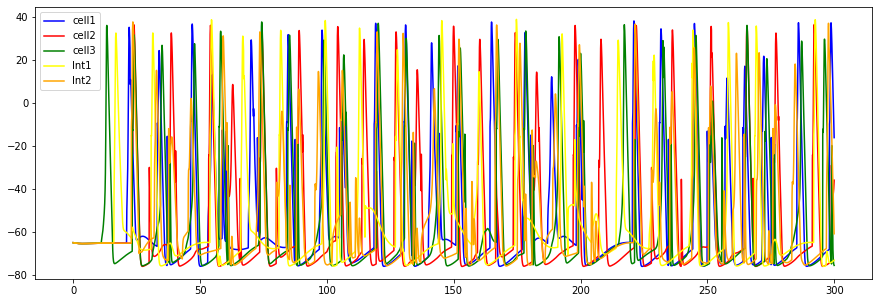

In [27]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v1, label='cell1', color='blue')
plt.plot(time, soma_v2, label='cell2', color='red')
plt.plot(time, soma_v3, label='cell3', color='green')
plt.plot(time, soma_v4, label='Int1', color='yellow')
plt.plot(time, soma_v5, label='Int2', color='orange')
plt.legend()
plt.show()

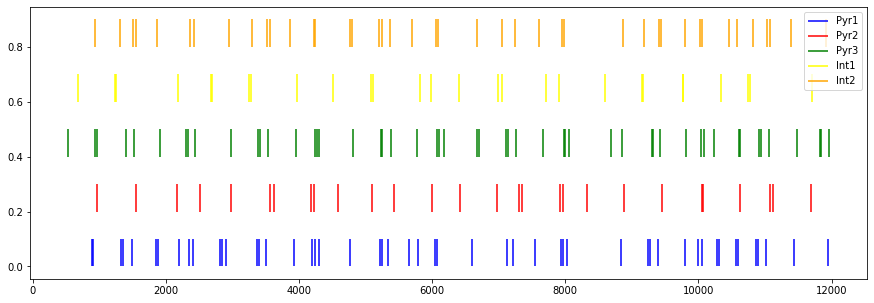

Spikes Pyr1  Pyr2  Pyr3  It1  Int2
----------------------------------
       51    28    52    28    42


In [28]:
spikes1 = spike_detector(soma_v1, -20.0)
spikes2 = spike_detector(soma_v2, -20.0)
spikes3 = spike_detector(soma_v3, -20.0)
spikes4 = spike_detector(soma_v4, -20.0)
spikes5 = spike_detector(soma_v5, -20.0)

plt.figure(figsize=(15,5))
plt.vlines(spikes1, ymin=0, ymax=0.1, color='blue', label='Pyr1')
plt.vlines(spikes2, ymin=0.2, ymax=0.3, color='red', label='Pyr2')
plt.vlines(spikes3, ymin=0.4, ymax=0.5, color='green', label='Pyr3')
plt.vlines(spikes4, ymin=0.6, ymax=0.7, color='yellow', label='Int1')
plt.vlines(spikes5, ymin=0.8, ymax=0.9, color='orange', label='Int2')
plt.legend()

plt.show()

print("Spikes Pyr1  Pyr2  Pyr3  It1  Int2")
print("----------------------------------")
print("      ", len(spikes1), "  ", len(spikes2), "  ", len(spikes3), "  ", len(spikes4), "  ", len(spikes5))

### 1. Reduce the connection weight between your cells to 0.2

In [29]:
# reduce connection weights, but maintaining the same connections
for con in netcons:
    con.weight[0] = 0.2

In [30]:
# record voltage from the soma and run the stimulation

recording_cell1 = Pyr1
recording_cell2 = Pyr2
recording_cell3 = Pyr3
recording_cell4 = Int1
recording_cell5 = Int2

soma_v1 = h.Vector().record(recording_cell1.soma[0](0.5)._ref_v)
soma_v2 = h.Vector().record(recording_cell2.soma[0](0.5)._ref_v)
soma_v3 = h.Vector().record(recording_cell3.soma[0](0.5)._ref_v)
soma_v4 = h.Vector().record(recording_cell4.soma[0](0.5)._ref_v)
soma_v5 = h.Vector().record(recording_cell5.soma[0](0.5)._ref_v)

time = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(300)

0.0

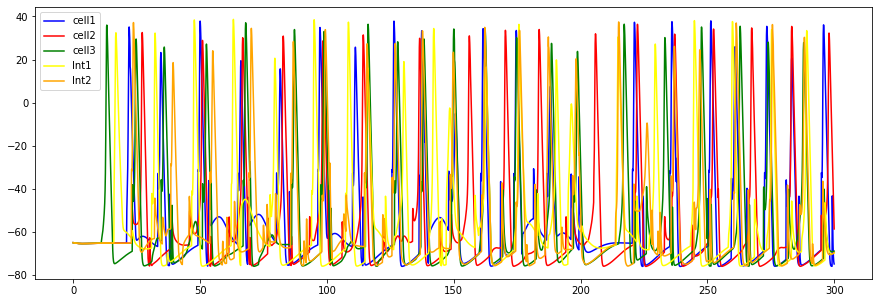

In [31]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v1, label='cell1', color='blue')
plt.plot(time, soma_v2, label='cell2', color='red')
plt.plot(time, soma_v3, label='cell3', color='green')
plt.plot(time, soma_v4, label='Int1', color='yellow')
plt.plot(time, soma_v5, label='Int2', color='orange')
plt.legend()
plt.show()

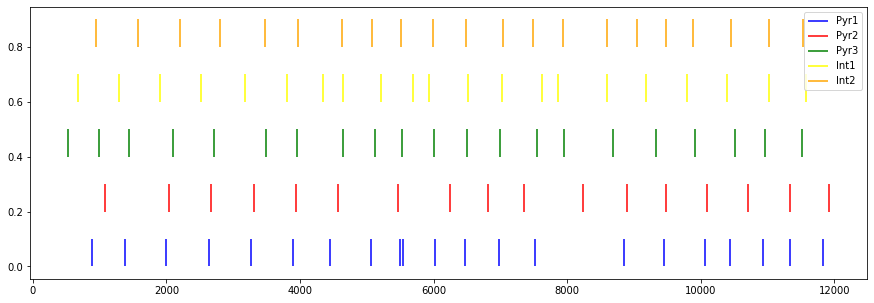

Spikes Pyr1  Pyr2  Pyr3  It1  Int2
----------------------------------
       21    17    21    21    21


In [32]:
spikes1 = spike_detector(soma_v1, -20.0)
spikes2 = spike_detector(soma_v2, -20.0)
spikes3 = spike_detector(soma_v3, -20.0)
spikes4 = spike_detector(soma_v4, -20.0)
spikes5 = spike_detector(soma_v5, -20.0)

plt.figure(figsize=(15,5))
plt.vlines(spikes1, ymin=0, ymax=0.1, color='blue', label='Pyr1')
plt.vlines(spikes2, ymin=0.2, ymax=0.3, color='red', label='Pyr2')
plt.vlines(spikes3, ymin=0.4, ymax=0.5, color='green', label='Pyr3')
plt.vlines(spikes4, ymin=0.6, ymax=0.7, color='yellow', label='Int1')
plt.vlines(spikes5, ymin=0.8, ymax=0.9, color='orange', label='Int2')
plt.legend()

plt.show()

print("Spikes Pyr1  Pyr2  Pyr3  It1  Int2")
print("----------------------------------")
print("      ", len(spikes1), "  ", len(spikes2), "  ", len(spikes3), "  ", len(spikes4), "  ", len(spikes5))

When we reduce the connection weights between our cells, we can observe that all of the cells, both excitatory in inhibitory decrease their firing frequency. This in turn, seems to help with the synchrony of our network. More precisely, our cells have a more reliable and regular firing pattern.

### 1. Connection weight to 1, and connection of exponential synapses to 0.2

In [33]:
# go back to connection weights of 1, maintaining the same random connections
for con in netcons:
    con.weight[0] = 1
    
# from 1 to 0.2
connection1.weight[0] = 0.2       
connection2.weight[0] = 0.2     
connection3.weight[0] = 0.2        
connection4.weight[0] = 0.2        
connection5.weight[0] = 0.2 

In [34]:
# record voltage from the soma and run the stimulation

recording_cell1 = Pyr1
recording_cell2 = Pyr2
recording_cell3 = Pyr3
recording_cell4 = Int1
recording_cell5 = Int2

soma_v1 = h.Vector().record(recording_cell1.soma[0](0.5)._ref_v)
soma_v2 = h.Vector().record(recording_cell2.soma[0](0.5)._ref_v)
soma_v3 = h.Vector().record(recording_cell3.soma[0](0.5)._ref_v)
soma_v4 = h.Vector().record(recording_cell4.soma[0](0.5)._ref_v)
soma_v5 = h.Vector().record(recording_cell5.soma[0](0.5)._ref_v)

time = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(300)

0.0

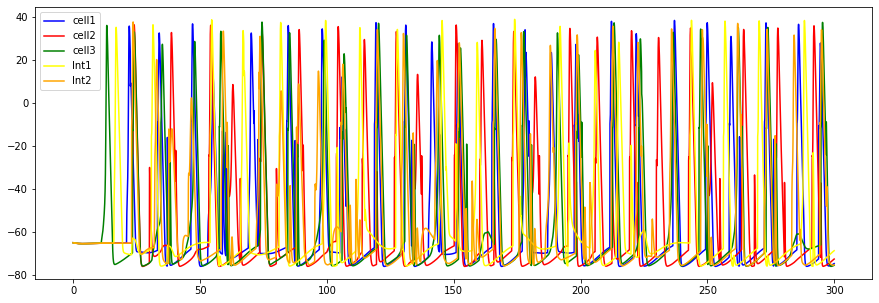

In [35]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v1, label='cell1', color='blue')
plt.plot(time, soma_v2, label='cell2', color='red')
plt.plot(time, soma_v3, label='cell3', color='green')
plt.plot(time, soma_v4, label='Int1', color='yellow')
plt.plot(time, soma_v5, label='Int2', color='orange')
plt.legend()
plt.show()

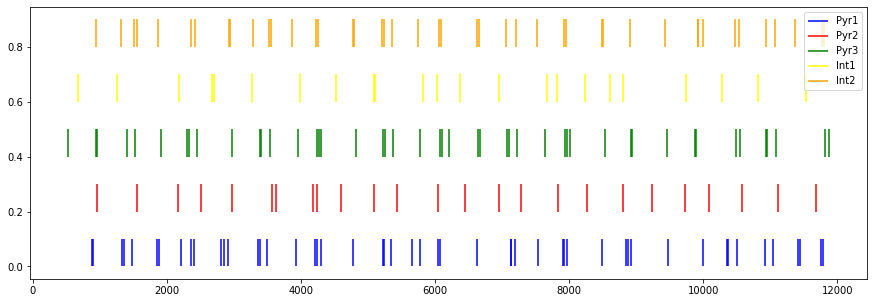

Spikes Pyr1  Pyr2  Pyr3  It1  Int2
----------------------------------
       51    25    47    23    44


In [36]:
spikes1 = spike_detector(soma_v1, -20.0)
spikes2 = spike_detector(soma_v2, -20.0)
spikes3 = spike_detector(soma_v3, -20.0)
spikes4 = spike_detector(soma_v4, -20.0)
spikes5 = spike_detector(soma_v5, -20.0)

plt.figure(figsize=(15,5))
plt.vlines(spikes1, ymin=0, ymax=0.1, color='blue', label='Pyr1')
plt.vlines(spikes2, ymin=0.2, ymax=0.3, color='red', label='Pyr2')
plt.vlines(spikes3, ymin=0.4, ymax=0.5, color='green', label='Pyr3')
plt.vlines(spikes4, ymin=0.6, ymax=0.7, color='yellow', label='Int1')
plt.vlines(spikes5, ymin=0.8, ymax=0.9, color='orange', label='Int2')
plt.legend()
plt.show()

print("Spikes Pyr1  Pyr2  Pyr3  It1  Int2")
print("----------------------------------")
print("      ", len(spikes1), "  ", len(spikes2), "  ", len(spikes3), "  ", len(spikes4), "  ", len(spikes5))

When we change the stimulation, the network behaves in a similar manner to our initial protocol. Overall, it seems that our network is driven more by the cell connectivity, as changing these connections significantly influece the firing frequency of individual cells and synchrony of the overall network.

# Ex4. Poissonian stimulus

<font size='3'>Load the five morphology reconstructions assigned to your group in week 2, using the class "Cell" defined in these tutorials. Connect the cells with the following weights: w(Pyr - Pyr) = 1, w(Pyr - Int) = 1, w(Inh - Pyr) = 1, w(Int - Int) = -0.01. Add exponential synapses (weight 1, tau = 2 ms) to a random section of the basal dendrite of each cell. 
Create two different poissonian stimulation processes for the exponential synapses of: subset1 - two excitatory neurons and one inhibitory and subset2 - one excitatory and one inhibitory neuron respectively,  with no more than 10 stimulations. Run a simulation that lasts long enough to contain the last stimulation. Plot the voltage response of each cell and spike detection.
Describe what you observe. What do you think a poissonian stimulation is useful for when simulationg networks? Is there any difference bewteen a poissonian stimulation and an irregular asynchronous stimualtion? [2 pts]

In [6]:
# Initialize cells

Pyr1 = Cell('morph_02.swc','Pyr1','Pyr')
Int1 = Cell('morph_03.swc','Int1','Int')
Int2 = Cell('morph_05.swc','Int2','Int')
Pyr2 = Cell('morph_06.swc','Pyr2','Pyr')
Pyr3 = Cell('morph_10.swc','Pyr3','Pyr')
cells_Pyr = [Pyr1, Pyr2, Pyr3]
cells_Int = [Int1, Int2]
cells = cells_Pyr + cells_Int

error morph_02.swc line 19419: could not parse: 
error morph_03.swc line 2503: could not parse: 
error morph_05.swc line 5778: could not parse: 
error morph_06.swc line 14778: could not parse: 
error morph_10.swc line 8181: could not parse: 


In [7]:
netcons = [] 

# Connect Pyr1 and Pyr2 to Pyr3
nc = connect(Pyr1,Pyr3,weight = 1)
netcons.append(nc)
nc = connect(Pyr2,Pyr3,weight = 1)
netcons.append(nc)

# Connect Pyr1 and Pyr3 to Pyr2
nc = connect(Pyr1,Pyr2,weight = 1)
netcons.append(nc)
nc = connect(Pyr3,Pyr2,weight = 1)
netcons.append(nc)

# Connect Pyr2 and Pyr3 to Pyr1
nc = connect(Pyr2,Pyr1,weight = 1)
netcons.append(nc)
nc = connect(Pyr3,Pyr1,weight = 1)
netcons.append(nc)

# Connect Pyr1, Pyr2 and Pyr 3 to Int2 
nc = connect(Pyr1,Int1,weight = 1)
netcons.append(nc)
nc = connect(Pyr2,Int1,weight = 1)
netcons.append(nc)
nc = connect(Pyr3,Int1,weight = 1)
netcons.append(nc)

# Connect Pyr1, Pyr2 and Pyr 3 to Int2 
nc = connect(Pyr1,Int2,weight = 1)
netcons.append(nc)
nc = connect(Pyr2,Int2,weight = 1)
netcons.append(nc)
nc = connect(Pyr3,Int2,weight = 1)
netcons.append(nc)

# Connect Int1 to Pyr1, Pyr2 and Pyr 3 
nc = connect(Int1,Pyr1,weight = 1,target_neurite='soma')
netcons.append(nc)
nc = connect(Int1,Pyr2,weight = 1,target_neurite='soma')
netcons.append(nc)
nc = connect(Int1,Pyr3,weight = 1,target_neurite='soma')
netcons.append(nc)

# Connect Int2 to Pyr1, Pyr2 and Pyr 3 
nc = connect(Int2,Pyr1,weight = 1,target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr2,weight = 1,target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr3,weight = 1,target_neurite='soma')
netcons.append(nc)

# Connect Int1 to Int2 and viceversa 
nc = connect(Int1,Int2,weight = -0.01,target_neurite='soma') 
netcons.append(nc)
nc = connect(Int2,Int1,weight = -0.01,target_neurite='soma')
netcons.append(nc)

Connected cells Pyr1 -> Pyr3 with weight 1 and delay 5, from axon[203] to dend[21]
Connected cells Pyr2 -> Pyr3 with weight 1 and delay 5, from axon[97] to dend[20]
Connected cells Pyr1 -> Pyr2 with weight 1 and delay 5, from axon[175] to dend[41]
Connected cells Pyr3 -> Pyr2 with weight 1 and delay 5, from axon[54] to dend[42]
Connected cells Pyr2 -> Pyr1 with weight 1 and delay 5, from axon[112] to dend[36]
Connected cells Pyr3 -> Pyr1 with weight 1 and delay 5, from axon[45] to dend[26]
Connected cells Pyr1 -> Int1 with weight 1 and delay 5, from axon[65] to dend[33]
Connected cells Pyr2 -> Int1 with weight 1 and delay 5, from axon[129] to dend[31]
Connected cells Pyr3 -> Int1 with weight 1 and delay 5, from axon[34] to dend[52]
Connected cells Pyr1 -> Int2 with weight 1 and delay 5, from axon[99] to dend[22]
Connected cells Pyr2 -> Int2 with weight 1 and delay 5, from axon[16] to dend[11]
Connected cells Pyr3 -> Int2 with weight 1 and delay 5, from axon[58] to dend[27]
Connected ce

In [8]:
# add exponential synapses

# get random sections 
sec1 = random.randint(0, len(Pyr1.dend)-1)
sec2 = random.randint(0, len(Pyr2.dend)-1)
sec3 = random.randint(0, len(Pyr3.dend)-1)
sec4 = random.randint(0, len(Int1.dend)-1)
sec5 = random.randint(0, len(Int2.dend)-1)

# create synapses 
stim_cell1 = Pyr1
synapse1 = h.ExpSyn(stim_cell1.dend[sec1](0.5))
synapse1.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr1' %sec1)

stim_cell2 = Pyr2
synapse2 = h.ExpSyn(stim_cell2.dend[sec2](0.5))
synapse2.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr2' %sec2)

stim_cell3 = Pyr3
synapse3 = h.ExpSyn(stim_cell3.dend[sec3](0.5))
synapse3.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr3' %sec3)

stim_cell4 = Int1
synapse4 = h.ExpSyn(stim_cell4.dend[sec4](0.5))
synapse4.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Int1' %sec4)

stim_cell5 = Int2
synapse5 = h.ExpSyn(stim_cell5.dend[sec5](0.5))
synapse5.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Int2' %sec5)

Stimulus apply in basal section num 19 of Pyr1
Stimulus apply in basal section num 32 of Pyr2
Stimulus apply in basal section num 25 of Pyr3
Stimulus apply in basal section num 15 of Int1
Stimulus apply in basal section num 24 of Int2


In [9]:
import random
import math

def generate_poisson_stim(lambda_ = 10, num_stims = 10, stim_time = 10):
    
    # For the given average stimulation rate λ, use the inverse-CDF technique to generate 
    # inter-stim times. Generate actual times by constructing a running-sum of the 
    # interval stim times.
    
    times = []
    lambda_ = lambda_
    num_stims = num_stims
    stim_time = stim_time
    times.append(stim_time)

    for i in range(num_stims-2):
        #Get the next probability value from Uniform(0,1)
        p = random.random()

        #Plug it into the inverse of the CDF of Exponential(_lamnbda)
        inter_time = -math.log(1.0 - p)/lambda_

        #Add the inter-arrival time to the running sum
        stim_time = stim_time + inter_time
        times.append(round(stim_time, 2))
    return times

In [11]:
stim_times1 = generate_poisson_stim(lambda_ = 0.05, num_stims = 10, stim_time = 10)
print('stimulation interval subset 1 = %s' %stim_times1)

stim_times2 = generate_poisson_stim(lambda_ = 0.024, num_stims = 10, stim_time = 20)
print('stimulation interval subset 2 = %s' %stim_times2)


stimulator1 = h.VecStim()
spike_times1 = stim_times1 # apply process 1
spikes_vector1 = h.Vector(spike_times1)
stimulator1.play(spikes_vector1)

stimulator2 = h.VecStim()
spike_times2 = stim_times1 # apply process 1
spikes_vector2 = h.Vector(spike_times2)
stimulator2.play(spikes_vector2)

stimulator3 = h.VecStim()
spike_times3 = stim_times2 # apply process 2
spikes_vector3 = h.Vector(spike_times3)
stimulator3.play(spikes_vector3)

stimulator4 = h.VecStim()
spike_times4 = stim_times1  # apply process 1
spikes_vector4 = h.Vector(spike_times4)
stimulator4.play(spikes_vector4)

stimulator5 = h.VecStim()
spike_times5 = stim_times2 # apply process 2
spikes_vector5 = h.Vector(spike_times5)
stimulator5.play(spikes_vector5)

connection1 = h.NetCon(stimulator1, synapse1)
connection1.weight[0] = 1       # In units of [nS] due to the gmax scaling factor in our .mod file
connection2 = h.NetCon(stimulator2, synapse2)
connection2.weight[0] = 1       # In units of [nS] due to the gmax scaling factor in our .mod file
connection3 = h.NetCon(stimulator3, synapse3)
connection3.weight[0] = 1        # In units of [nS] due to the gmax scaling factor in our .mod file
connection4 = h.NetCon(stimulator4, synapse4)
connection4.weight[0] = 1        # In units of [nS] due to the gmax scaling factor in our .mod file
connection5 = h.NetCon(stimulator5, synapse5)
connection5.weight[0] = 1        # In units of [nS] due to the gmax scaling factor in our .mod file

# record voltage from the soma and run the stimulation

recording_cell1 = Pyr1
recording_cell2 = Pyr2
recording_cell3 = Pyr3
recording_cell4 = Int1
recording_cell5 = Int2

soma_v1 = h.Vector().record(recording_cell1.soma[0](0.5)._ref_v)
soma_v2 = h.Vector().record(recording_cell2.soma[0](0.5)._ref_v)
soma_v3 = h.Vector().record(recording_cell3.soma[0](0.5)._ref_v)
soma_v4 = h.Vector().record(recording_cell4.soma[0](0.5)._ref_v)
soma_v5 = h.Vector().record(recording_cell5.soma[0](0.5)._ref_v)

time = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(max(stim_times2) + 20)

stimulation interval subset 1 = [10, 16.23, 27.99, 35.74, 49.59, 76.33, 84.74, 112.93, 121.81]
stimulation interval subset 2 = [20, 21.31, 92.11, 103.0, 151.29, 190.35, 201.54, 238.3, 313.07]


0.0

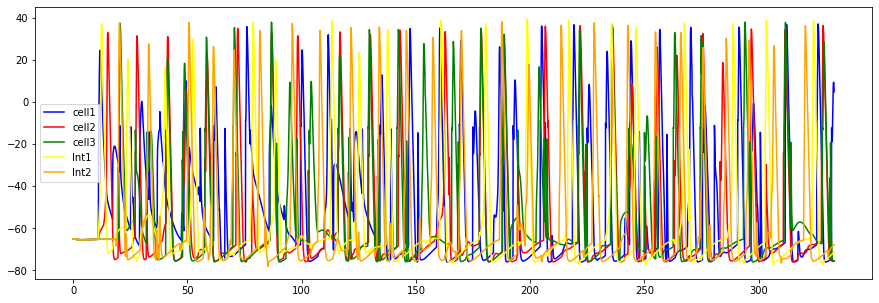

In [12]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v1, label='cell1', color='blue')
plt.plot(time, soma_v2, label='cell2', color='red')
plt.plot(time, soma_v3, label='cell3', color='green')
plt.plot(time, soma_v4, label='Int1', color='yellow')
plt.plot(time, soma_v5, label='Int2', color='orange')
plt.legend()
plt.show()

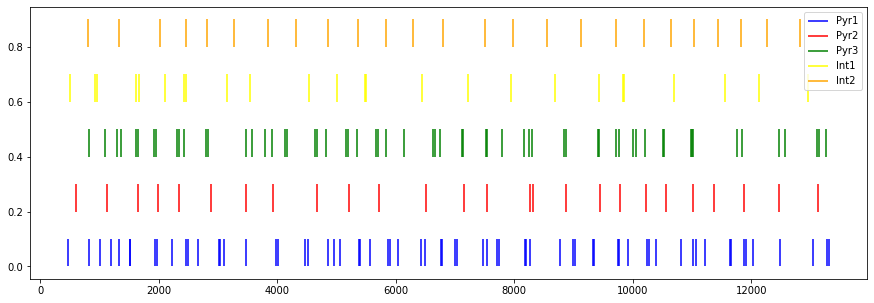

Spikes Pyr1  Pyr2  Pyr3  It1  Int2
----------------------------------
       67    26    61    25    25


In [13]:
spikes1 = spike_detector(soma_v1, -20.0)
spikes2 = spike_detector(soma_v2, -20.0)
spikes3 = spike_detector(soma_v3, -20.0)
spikes4 = spike_detector(soma_v4, -20.0)
spikes5 = spike_detector(soma_v5, -20.0)

plt.figure(figsize=(15,5))
plt.vlines(spikes1, ymin=0, ymax=0.1, color='blue', label='Pyr1')
plt.vlines(spikes2, ymin=0.2, ymax=0.3, color='red', label='Pyr2')
plt.vlines(spikes3, ymin=0.4, ymax=0.5, color='green', label='Pyr3')
plt.vlines(spikes4, ymin=0.6, ymax=0.7, color='yellow', label='Int1')
plt.vlines(spikes5, ymin=0.8, ymax=0.9, color='orange', label='Int2')
plt.legend()
plt.show()

print("Spikes Pyr1  Pyr2  Pyr3  It1  Int2")
print("----------------------------------")
print("      ", len(spikes1), "  ", len(spikes2), "  ", len(spikes3), "  ", len(spikes4), "  ", len(spikes5))

Describe what you observe. What do you think a poissonian stimulation is useful for when simulationg networks? Is there any difference bewteen a poissonian stimulation and an irregular asynchronous stimualtion?

A poissonian stimulation might be use when the experimenter belives or the literature suggest that the timing of individual spikes conveys little or no information. More specifically, their timing, interval and patterns do not convey important information about the cortical/network organization.

When using a poissonian stimulation we can observe differences in the firing pattern compared to the protocol used in exercise 3. These differences are extremly variabled for different cells. For example, using a Poissonian stimulation seems to decrease the firing frequency of interneuron 2, as well as make its firing pattern more regular. On the other hand if we look at pyramidal cell 1, the differences between the two stimulation are not as straight forward. It seems that its firing is considerably the shape of the elicit spikes. Moreover, it also influence the frequency of the firing at different time points.


As we previously stated, one would use a Poisson process if the irregular interspike interval is believed to be a random process, rather than a result of coincidences of presynaptic events.  This implies that an estimate of spiking activity/rate can be obtained through averaging across individual cells. On the contrary, in the irregular asynchronus stimulation, the spike times and their patterns will convery important information.